<b>Data mining project - 2020/21</b><br>
<b>Authors</b>: [Alexandra Bradan](https://github.com/alexandrabradan), [Alice Graziani](https://github.com/alicegraziani25) and [Eleonora Cocciu](https://github.com/eleonoracocciu)<br>
<b>Python version</b>: 3.x<br>
<b>Last update: 21/05/2021<b>

In [57]:
# system library
import os
import sys
import json
import tqdm
import ast

# useful libraries
import math
import operator
import itertools
import statistics
import collections
from collections import Counter
from collections import OrderedDict

# pandas
import pandas as pd

# numpy
import numpy as np
from numpy import std
from numpy import mean
from numpy import percentile

# visualisarion
import pydotplus
import seaborn as sns
from matplotlib import colors
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from IPython.display import Image

# sklearn
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import classification_report, confusion_matrix

# dimensional reducers
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif  # classification
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression  # regression

# scalers
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import OneHotEncoder

# performance visualisation 
from sklearn import tree
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall
from scikitplot.metrics import plot_cumulative_gain
from scikitplot.metrics import plot_lift_curve
from sklearn.model_selection import learning_curve
from mlxtend.plotting import plot_decision_regions
from yellowbrick.model_selection import LearningCurve

# tree classifiers
from sklearn.tree import DecisionTreeClassifier

# linear classifiers
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Perceptron
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

# neighbors classifiers
from sklearn.neighbors import KNeighborsClassifier

# naive_bayes classifiers
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB

# ensemble classifiers
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

# svm
from sklearn.svm import SVC
from sklearn.svm import LinearSVC

plt.rcParams["patch.force_edgecolor"] = True
%matplotlib inline

from yellowbrick.style import set_palette
set_palette('bold')

In [58]:
model_name = "MLPClassifier_1_layer"

<h6> Datasets loading </h6>

In [59]:
X_train = pd.read_csv('../../data/fma_metadata/X_train_merged.csv', index_col=0)
X_test = pd.read_csv('../../data/fma_metadata/X_test.csv', index_col=0)

y_train = pd.read_csv('../../data/fma_metadata/y_train_merged.csv', index_col=0)
y_test = pd.read_csv('../../data/fma_metadata/y_test.csv', index_col=0)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(92834, 55) (10874, 55)
(92834, 1) (10874, 1)


<h6>Continous, categorical/ordinal column retrieval</h6>

In [60]:
numeric_columns = []  # continous variables
for column_name in X_train.columns:
    if ("track_genre_top" not in column_name) and  \
          ("track_date_created_year" not in column_name) and \
            ("track_date_created_season" not in column_name):
                numeric_columns.append(column_name)
print("numeric_columns", len(numeric_columns))

numeric_columns 37


In [61]:
categoric_columns = []  # ordinal or categorical variables
for column_name in X_train.columns:
    if ("track_genre_top" in column_name) or  \
          ("track_date_created_year" in column_name) or \
            ("track_date_created_season" in column_name):
                categoric_columns.append(column_name)
print("categoric_columns", len(categoric_columns))

categoric_columns 18


<h6>Define current (filtered) train and test</h6>

In [62]:
X_tr = X_train[numeric_columns].copy()
y_tr = y_train.copy()
X_ts = X_test[numeric_columns].copy()
y_ts = y_test.copy()

"""
X_tr = X_train.copy()
y_tr = y_train.copy()
X_ts = X_test.copy()
y_ts = y_test.copy()
"""

'\nX_tr = X_train.copy()\ny_tr = y_train.copy()\nX_ts = X_test.copy()\ny_ts = y_test.copy()\n'

<h6>Load the black-box model</h6>

In [63]:
import pickle

model_info = None
model = None
with open('pickle/' + model_name + '_numeric.pickle', 'rb') as handle:
    model_info = pickle.load(handle)
    bb = model_info['tuned_model']

Trying to unpickle estimator StandardScaler from version 0.24.0 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
Trying to unpickle estimator LabelBinarizer from version 0.24.0 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
Trying to unpickle estimator MLPClassifier from version 0.24.0 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.


In [64]:
bb 

MLPClassifier(activation='tanh', alpha=0.001, hidden_layer_sizes=(5,),
              learning_rate='invscaling', momentum=0.2, random_state=42,
              tol=0.01)

<h6>Filter attributes</h6>

In [65]:
if model_info['model_name'] != 'Plain':
    n_features = model_info['params']['rfe__n_features_to_select']
    best_features = model_info['best_features']

    if n_features == len(best_features):
        X_tr = X_tr[best_features].copy()
        X_ts = X_ts[best_features].copy()
    else:
        print("Wrong feature filtering")
        sys.exit(-1)

<h6>Scale data </h6>

In [66]:
try:
    for column_name in X_tr.columns:
        scaler = model_info['params']['preprocessor__numeric__scaler']
        X_tr[column_name] = scaler.fit_transform(X_tr[column_name].values.reshape(-1,1))[:, 0]
        X_ts[column_name] = scaler.transform(X_ts[column_name].values.reshape(-1,1))[:, 0]
except KeyError:
    pass

<h6>Train model (again, for certainty)</h6>

In [67]:
bb.fit(X_tr.values, y_tr.values.ravel())

MLPClassifier(activation='tanh', alpha=0.001, hidden_layer_sizes=(5,),
              learning_rate='invscaling', momentum=0.2, random_state=42,
              tol=0.01)

In [68]:
def bb_predict(X):
    return bb.predict(X)

def bb_predict_proba(X):
    return bb.predict_proba(X)

In [69]:
y_pred = bb_predict(X_ts.values)
y_prob = bb_predict_proba(X_ts.values)

<h1> Local XAIs </h1>

<h6> Select correctly predicted records to explain </h6>

In [70]:
i2e_list = []
for i2e, (y_t, y_p) in enumerate(zip(y_ts.values.ravel(), y_pred)):
    if (y_t == y_p) and (y_t == 1):
        i2e_list.append(i2e)

In [71]:
len(i2e_list)

243

In [72]:
len([x for x in y_ts.values.ravel() if x == 1])

1080

In [73]:
list_of_series = []
list_of_series2 = []
for i2e in i2e_list:
    list_of_series.append(X_ts.iloc[i2e])
    list_of_series2.append(y_ts.iloc[i2e])

df = pd.concat(list_of_series, axis=1).transpose()
y = pd.concat(list_of_series2, axis=1).transpose()

In [74]:
merged_df = pd.merge(df, y, left_index=True, right_index=True)

<h2>SHAP explanaibility </h2>
Shapley value: It is the average of the marginal contributions across all permutations. 

In [75]:
import shap
shap.initjs()

In [77]:
explainer = shap.KernelExplainer(bb.predict_proba, df.values)
shap_values = explainer.shap_values(df.values)

Using 243 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


<h6>Partial Dependence Plots (show how a single feature impacts predictions)</h6>

Canvariable importance plot show the directions between the features and the target variable? Yes, that's the power of the Shap value plot as shown below. This plot is made of many dots. Each dot has three characteristics. The graph below plots the SHAP values of every feature for every sample. It shorts features by the total of absolute SHAP values over all samples. The color represents the feature value (red high, blue low).

The vertical location shows the feature importance.
The horizontal location shows whether the effect of that value caused a higher or lower prediction.
Color shows whether that feature was high or low for that observation


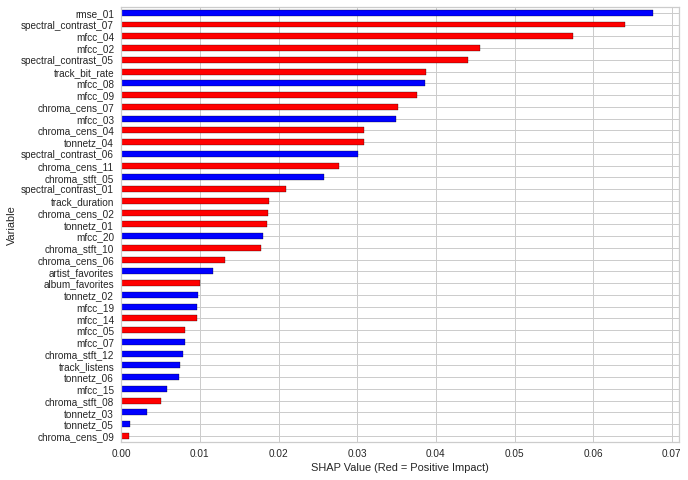

In [78]:
def ABS_SHAP(df_shap,df):
    #import matplotlib as plt
    # Make a copy of the input data
    shap_v = pd.DataFrame(df_shap)
    feature_list = df.columns
    shap_v.columns = feature_list
    df_v = df.copy().reset_index().drop('index',axis=1)
    
    # Determine the correlation in order to plot with different colors
    corr_list = list()
    for i in feature_list:
        b = np.corrcoef(shap_v[i],df_v[i])[1][0]
        corr_list.append(b)
    corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
    # Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
    corr_df.columns  = ['Variable','Corr']
    corr_df['Sign'] = np.where(corr_df['Corr']>0,'red','blue')
    
    # Plot it
    shap_abs = np.abs(shap_v)
    k=pd.DataFrame(shap_abs.mean()).reset_index()
    k.columns = ['Variable','SHAP_abs']
    k2 = k.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')
    k2 = k2.sort_values(by='SHAP_abs',ascending = True)
    colorlist = k2['Sign']
    ax = k2.plot.barh(x='Variable',y='SHAP_abs',color = colorlist, figsize=(10,8),legend=False)
    ax.set_xlabel("SHAP Value (Red = Positive Impact)")
    
ABS_SHAP(shap_values[1], df)

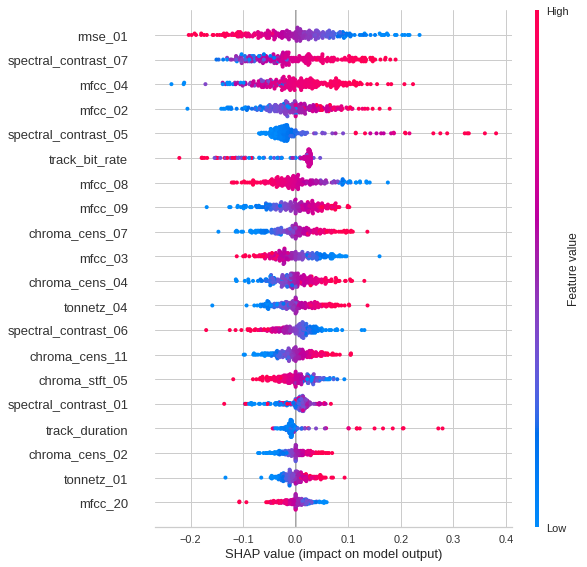

In [79]:
shap.summary_plot(shap_values[1], df.values, feature_names=df.columns.to_list())

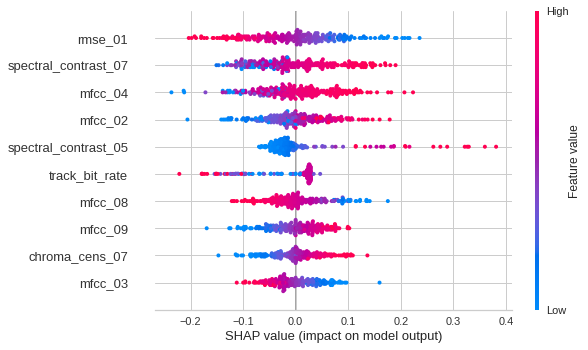

In [82]:
shap.summary_plot(shap_values[1], df.values, feature_names=df.columns.to_list(), max_display=10)

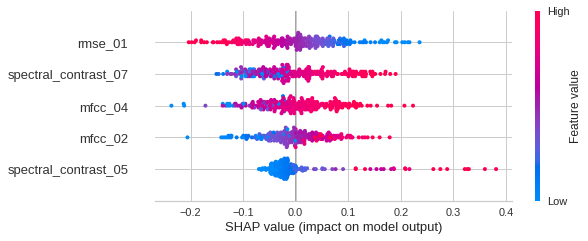

In [81]:
shap.summary_plot(shap_values[1], df.values, feature_names=df.columns.to_list(), max_display=5)

According to SHAP summary plots, Live\_Recording prediction is associated with the following characteristics:
- low to medium \emph{track\_bit\_rate};
- low \emph{mfcc\_03} value;
- low \emph{mfcc\_20};
- low \emph{rmse\_01};
- high \emph{mfcc\_02};
- low \emph{track\_listens};
- low \emph{mfcc\_07};
- low \emph{tonnetz\_02};
- low \emph{mfcc\_19};
- low \emph{mfcc\_14};
- low \emph{mfcc\_08};
- low \emph{artist\_favorites};
- high \emph{spectral\_contrast\_06};
- low \emph{track\_duration};

<h6>Dependence Contribution Plots (show the  distribution of effects)</h6>

Each dot represents a row of the data. The horizontal location is the actual value from the dataset, and the vertical location shows what having that value did to the prediction. The fact this slopes upward says that the more you possess the ball, the higher the model's prediction is for winning the Man of the Match award.

In [83]:
explainer = shap.KernelExplainer(bb.predict_proba, df.values)
shap_values2 = explainer.shap_values(df.values)

Using 243 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


for column_name in df.columns:
    if column_name != "album_type" and column_name != "track_bit_rate":
        shap.dependence_plot(column_name, shap_values2[1], df, interaction_index="track_bit_rate")

In [90]:
filtered_features_top_14 = ['rmse_01', 'spectral_contrast_07',  'mfcc_04', 'mfcc_02', 'spectral_contrast_05',
                    'track_bit_rate', 'mfcc_08', 'mfcc_09', 'chroma_cens_07', 'mfcc_03',
                            'chroma_cens_04', 'tonetz_04', 'spectral_contrast_06', "chroma_cens_11"]
filtered_features_top_5 = filtered_features_top_14[:5]

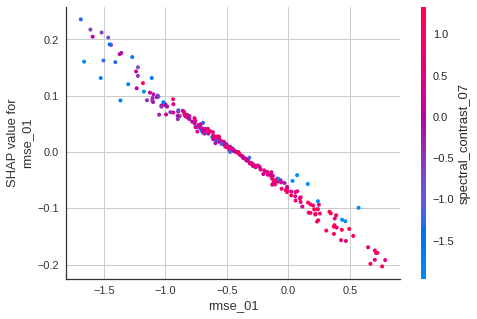

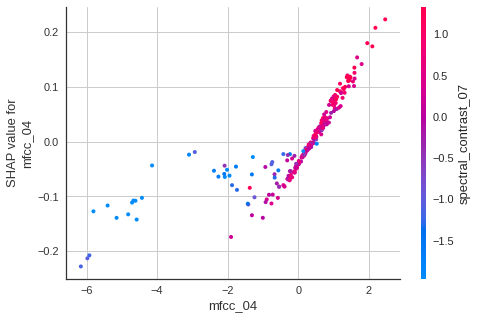

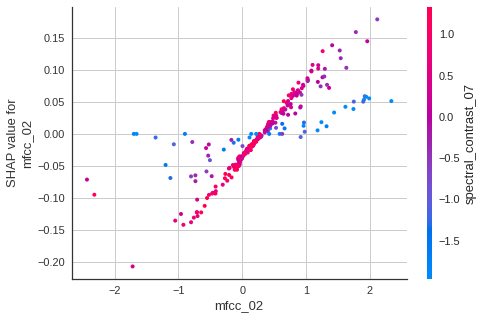

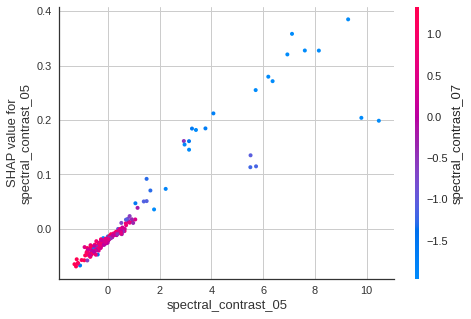

In [92]:
for column_name in filtered_features_top_5:
    if column_name != "spectral_contrast_07":
        shap.dependence_plot(column_name, shap_values2[1], df, interaction_index="spectral_contrast_07")

In [95]:
df_filtered = df[filtered_features_top_5]

explainer = shap.KernelExplainer(bb.predict_proba, df_filtered.values)
shap_interaction_values = explainer.shap_interaction_values(df_filtered)

shap.summary_plot(shap_interaction_values, df_filtered)